# Instructions For Pairwise Comparison

2019-06-26

This notebook contains instructions and explanations for using the pairwise module in the development version of tcrdist2. It is meant for Kosh, Phil, and Andrew rather than for an end user.

In [17]:
import pandas as pd
import tcrdist as td
from tcrdist import pairwise # for functions that are not going to be public

### getting test sequences

#### adaptive immunoseq

One option is to use`td.adaptive100` a test set of 100 cdr3 sequences generated from adaptive immunoseq data. It contains some sequences with * characters.

```python
td.adaptive100[32:35]
```
> ['CAAGYTGNQFYF', 'PLACQGNLIF', 'CAVRD*RGRGSTLGRLYF']


#### random amino acids

Another option for generating as many seqs is the function 

```python
td.get_k_ramdom_amino_acid_of_length_n(1000, 20)
```


## Flexible Pairwise Distance Computation Using Multiprocessing

The core function for pairwise comparison is `apply_pw_distance_metric_w_multiprocessing`. It takes three arguments

1. `sequences` - list of amino acid sequence strings
2. `f` - function that references unique_seqs and can iterate over a list of (i,j) tuples 
3. `processes` (which defaults to multiprocessing.cpu_count())

The function is meant to (1) take advantage of multiple CPUs and (2) be generalizable to any distance metric. Here we elaborate on those two points.

- `multiprocessing.map():` All comparison are stored in a list of tuples `[(i,j),(i,j),... (i,j)]`. The pairwise distance computation are split into chunks and a subset of the tuples are passed to each parrallel interpretter. Each interpretter is initialized with the full list of seqs (as `unique_seqs` in the global namespace), its unique sublist of tuples `[(i,j), ... (i,j)]` specifies its share of comparisons between the ith and jth seqs. 

- `f`: is a function mapped to the parrallel processes. The function f must interate over a list of `(i,j)` tuples and references `unique_seqs` via slices to `unique_seqs[i]` and `unique_seqs[j]`. Here is an example:

```python
def example_f:
    output_tuples = []
    for i,j in indices:
        d = distance_wrapper(unique_seqs[i], unique_seqs[j])
        output_tuples.append((i,j,d, unique_seqs[i], unique_seqs[j]))
    return(output_tuples)
```

Note that `distance_wapper()` is kept general so that it can be specified as an function that takes two strings and returns a metric.

```python
def distance_wrapper(a,b):
    return(your_favorite_metric(a, b))
```

For instance, we can later us a case/switch implementation to change the distance_wrapper so that it could be specified to be: 


#### Reciprocal Needlman-Wunsch alignment score

```python
def distance_wrapper(a,b):
    return(nw_metric(a, b))
```
where nw_metric refers to:
```python
def nw_metric(s1, s2):
    """
    E. Halpering, J. Buhler, R. Karp, R. Krauthgamer, and B. Westover.
    Detecting protein sequence conservation via metric embeddings.
    Bioinformatics, 19 (sup 1) 2003
    """
    xx = parasail.nw_stats(s1, s1, open=3, extend=3, matrix=parasail.blosum62).score
    yy = parasail.nw_stats(s2, s2, open=3, extend=3, matrix=parasail.blosum62).score
    xy = parasail.nw_stats(s1, s2, open=3, extend=3, matrix=parasail.blosum62).score
    D = xx + yy - 2 * xy
    return D
```

## - or -  

#### scipy.hamming_distance after pairwise Needlman-Wunsch alignment

```python 
def distance_wrapper(a,b):
    return(float(SequencePair(a, b).hamming_distance) )
```



# Using Pairwise Comparision via some Illustrative Examples

#### apply nw_metric to 3 seqs

In [18]:
pw = td.apply_pw_distance_metric_w_multiprocessing(
    sequences = td.adaptive100[32:35], 
    f = pairwise._f_pwdist_parallel_using_nw_metric,
    processes = 2)

##### result of pairwise comparison as a data.frame

In [19]:
pd.DataFrame(td.flatten(pw), columns=['i', 'j', 'd','seq_i','seq_j'])

,i,j,d,seq_i,seq_j
0,0,0,0,CAAGYTGNQFYF,CAAGYTGNQFYF
1,0,1,110,CAAGYTGNQFYF,PLACQGNLIF
2,0,2,127,CAAGYTGNQFYF,CAVRD*RGRGSTLGRLYF
3,1,1,0,PLACQGNLIF,PLACQGNLIF
4,1,2,163,PLACQGNLIF,CAVRD*RGRGSTLGRLYF
5,2,2,0,CAVRD*RGRGSTLGRLYF,CAVRD*RGRGSTLGRLYF


##### result packed into a distance matrix

In [20]:
pairwise._pack_matrix(pw)

array([[   0.,  110.,  127.],
       [ 110.,    0.,  163.],
       [ 127.,  163.,    0.]])

#### another genaralization to a different metric

In [21]:
pw = td.apply_pw_distance_metric_w_multiprocessing(
    sequences = td.adaptive100[32:35], 
    f = pairwise._f_pwdist_parallel_using_distance_wrapper,
    processes = 2)

In [22]:
pd.DataFrame(td.flatten(pw), columns=['i', 'j', 'd','seq_i','seq_j'])

,i,j,d,seq_i,seq_j
0,0,0,0.000000,CAAGYTGNQFYF,CAAGYTGNQFYF
1,0,1,0.666667,CAAGYTGNQFYF,PLACQGNLIF
2,0,2,0.631579,CAAGYTGNQFYF,CAVRD*RGRGSTLGRLYF
3,1,1,0.000000,PLACQGNLIF,PLACQGNLIF
4,1,2,0.833333,PLACQGNLIF,CAVRD*RGRGSTLGRLYF
5,2,2,0.000000,CAVRD*RGRGSTLGRLYF,CAVRD*RGRGSTLGRLYF


In [23]:
pairwise._pack_matrix(pw)

array([[ 0.        ,  0.66666667,  0.63157895],
       [ 0.66666667,  0.        ,  0.83333333],
       [ 0.63157895,  0.83333333,  0.        ]])

### timed comparisons

Using 'multiprocessing' does speed things up but only by a factor of 4 when using 10 cores and 10 chunks. It is possible that more chunks than processes may be faster if computation times finish asynchronously. Optimize this later!

In [24]:
aa2k = td.get_k_ramdom_amino_acid_of_length_n(2000, 10)

### 2000 x 2000 comparison on 10 cores: 11 secs

In [25]:
%time pw = td.apply_pw_distance_metric_w_multiprocessing(sequences = aa2k, f = pairwise._f_pwdist_parallel_using_nw_metric, processes = 10)

CPU times: user 3.46 s, sys: 322 ms, total: 3.78 s
Wall time: 11.5 s


#### 2000 x 2000 comparison on 1 core in series: 45.5 sec

In [26]:
def f(indices):
    output_tuples = []
    for i,j in indices:
        d = td.nw_metric(unique_seqs[i], unique_seqs[j])
        output_tuples.append((i,j,d, unique_seqs[i], unique_seqs[j]))
    return(output_tuples)
indices = td.get_pwdist_indices(aa2k)
unique_seqs = aa2k
%time pw_in_series = f(indices)

CPU times: user 47.4 s, sys: 220 ms, total: 47.6 s
Wall time: 47.7 s


#### In series just the distance calc without the other informatino packed in:

In [27]:
indices = td.get_pwdist_indices(aa2k)
%time pw_dist_only = [td.nw_metric(aa2k[i],aa2k[j]) for i,j in indices]

CPU times: user 47.1 s, sys: 208 ms, total: 47.4 s
Wall time: 47.5 s


In [28]:
pd.DataFrame(pw_in_series, columns=['i', 'j', 'd','seq_i','seq_j']).head()

,i,j,d,seq_i,seq_j
0,0,0,0,FHTNIPQHCK,FHTNIPQHCK
1,0,1,138,FHTNIPQHCK,DSSGTCYYRA
2,0,2,131,FHTNIPQHCK,LAACSGDCMY
3,0,3,142,FHTNIPQHCK,AYSDHRGGWS
4,0,4,139,FHTNIPQHCK,RGGLGYANPT


In [29]:
pd.DataFrame(td.flatten(pw), columns=['i', 'j', 'd','seq_i','seq_j']).head()

,i,j,d,seq_i,seq_j
0,0,0,0,FHTNIPQHCK,FHTNIPQHCK
1,0,1,138,FHTNIPQHCK,DSSGTCYYRA
2,0,2,131,FHTNIPQHCK,LAACSGDCMY
3,0,3,142,FHTNIPQHCK,AYSDHRGGWS
4,0,4,139,FHTNIPQHCK,RGGLGYANPT


In [30]:
pairwise._pack_matrix(pw).shape

(2000, 2000)

In [31]:
from matplotlib import pyplot
%matplotlib inline

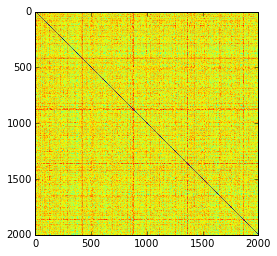

In [32]:
pyplot.imshow(pairwise._pack_matrix(pw))

### Another Example: Visual clustring td.adaptive100 cdr3 seqs based on Needlman-Wunsch Reciprocal Dist

In [33]:
pw2 = td.apply_pw_distance_metric_w_multiprocessing(
    sequences = td.adaptive100, 
    f = pairwise._f_pwdist_parallel_using_nw_metric,
    processes = 2)

In [34]:
import seaborn as sns

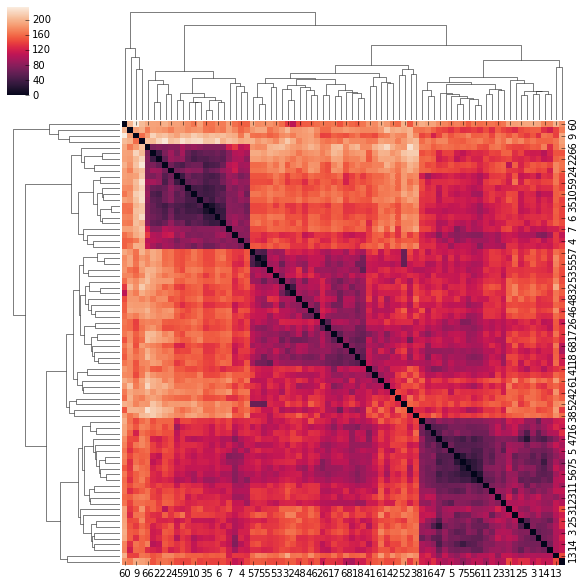

In [35]:
sns.clustermap(pairwise._pack_matrix(pw2))